In [43]:

#objectives

# data processing
# converting time stamp to date time
# enconding categorical variables
# selecting features and target
# spliting the data
# training the RFG model
# evaluating the model
#classification to predict status and recommendation
# predicting moisture for new data
# determine status and recommendation

In [44]:


import pandas as pd # type: ignore
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model  # type: ignore
from tensorflow.keras.layers import Input, Dense  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore
import warnings
warnings.filterwarnings('ignore')

In [45]:

df = pd.read_csv('soil_moisture3.csv')
df.head()

,record_id,sensor_id,location,soil_moisture_percent,temperature_celsius,humidity_percent,timestamp,status,battery_voltage,irrigation_action
0,1,SENSOR_4,Farm B,25.60,29.9,41.1,2025-07-03 4:32:45,Wet,3.62,Reduce Irrigation
1,2,SENSOR_1,Farm A,57.29,27.1,62.5,2025-07-01 0:30:45,Critical Low,3.58,Irrigate
2,3,SENSOR_9,Farm C,45.26,23.3,82.4,2025-07-03 10:39:45,Dry,3.03,Irrigate
3,4,SENSOR_8,Farm C,37.93,31.8,73.9,2025-06-30 23:43:45,Dry,3.41,Irrigate
4,5,SENSOR_8,Farm A,13.58,29.6,78.4,2025-07-04 3:53:45,Dry,3.46,Irrigate


In [46]:
df.columns

Index(['record_id', 'sensor_id', 'location', 'soil_moisture_percent',
       'temperature_celsius', 'humidity_percent', 'timestamp', 'status',
       'battery_voltage', 'irrigation_action'],
      dtype='object')

In [47]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   record_id              50000 non-null  int64  
 1   sensor_id              50000 non-null  object 
 2   location               50000 non-null  object 
 3   soil_moisture_percent  50000 non-null  float64
 4   temperature_celsius    50000 non-null  float64
 5   humidity_percent       50000 non-null  float64
 6   timestamp              50000 non-null  object 
 7   status                 50000 non-null  object 
 8   battery_voltage        50000 non-null  float64
 9   irrigation_action      40138 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


In [48]:
df.describe(include='all')

,record_id,sensor_id,location,soil_moisture_percent,temperature_celsius,humidity_percent,timestamp,status,battery_voltage,irrigation_action
count,50000.000000,50000,50000,50000.000000,50000.000000,50000.000000,50000,50000,50000.000000,40138
unique,NaN,20,4,NaN,NaN,NaN,49990,5,NaN,2
top,NaN,SENSOR_3,Farm D,NaN,NaN,NaN,2025-07-03 9:52:45,Critical High,NaN,Reduce Irrigation
freq,NaN,5616,12671,NaN,NaN,NaN,2,10233,NaN,20205
mean,25000.500000,NaN,NaN,49.626290,29.955624,54.239918,NaN,NaN,3.401807,NaN
std,14433.901067,NaN,NaN,32.300608,4.699756,19.469679,NaN,NaN,0.232759,NaN
min,1.000000,NaN,NaN,0.000000,18.100000,20.003272,NaN,NaN,3.000000,NaN
25%,12500.750000,NaN,NaN,19.050000,26.458015,37.605830,NaN,NaN,3.200783,NaN
50%,25000.500000,NaN,NaN,50.150000,29.938834,50.490713,NaN,NaN,3.401732,NaN
75%,37500.250000,NaN,NaN,80.222500,33.455912,72.787952,NaN,NaN,3.600972,NaN


In [49]:
df.isnull().sum()

record_id                   0
sensor_id                   0
location                    0
soil_moisture_percent       0
temperature_celsius         0
humidity_percent            0
timestamp                   0
status                      0
battery_voltage             0
irrigation_action        9862
dtype: int64

In [50]:
categorical_cols = ['irrigation_action']
for col in categorical_cols:
    if col in df.columns:
       df[col] = df[col].fillna('None')
        
print(df.isnull().sum())

record_id                0
sensor_id                0
location                 0
soil_moisture_percent    0
temperature_celsius      0
humidity_percent         0
timestamp                0
status                   0
battery_voltage          0
irrigation_action        0
dtype: int64


In [51]:

print(f"Number of duplicates: {df.duplicated().sum()}")


Number of duplicates: 0


In [52]:
num_cols = ['soil_moisture_percent', 'temperature_celcius', 'humidity_percent', 'battery_voltage']
for col in num_cols:
    if col in df.columns:
        # Remove extreme outliers (beyond 3 standard deviations)
        mean = df[col].mean()
        std = df[col].std()
        df[col] = np.where((df[col] < mean - 3*std) | (df[col] > mean + 3*std), np.nan, df[col])
        df[col] = df[col].fillna(df[col].median())

In [53]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   record_id              50000 non-null  int64  
 1   sensor_id              50000 non-null  object 
 2   location               50000 non-null  object 
 3   soil_moisture_percent  50000 non-null  float64
 4   temperature_celsius    50000 non-null  float64
 5   humidity_percent       50000 non-null  float64
 6   timestamp              50000 non-null  object 
 7   status                 50000 non-null  object 
 8   battery_voltage        50000 non-null  float64
 9   irrigation_action      50000 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB
None


In [54]:
#convert timestamp to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', dayfirst=True, errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday

print(df[['timestamp', 'hour', 'day', 'month', 'weekday']].head(10))



            timestamp  hour  day  month  weekday
0 2025-07-03 04:32:45     4    3      7        3
1 2025-07-01 00:30:45     0    1      7        1
2 2025-07-03 10:39:45    10    3      7        3
3 2025-06-30 23:43:45    23   30      6        0
4 2025-07-04 03:53:45     3    4      7        4
5 2025-07-04 04:03:45     4    4      7        4
6 2025-07-07 06:41:45     6    7      7        0
7 2025-07-03 00:36:45     0    3      7        3
8 2025-07-04 09:43:45     9    4      7        4
9 2025-07-07 10:28:45    10    7      7        0


In [55]:
# Encoding categorical variables

import pickle
from sklearn.preprocessing import LabelEncoder
le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['location'])

le_status = LabelEncoder()
df['status_encoded'] = le_status.fit_transform(df['status'])

le_action = LabelEncoder()
df['irrigation_action_encoded'] = le_action.fit_transform(df['irrigation_action'])

with open('action_encoder.pkl', 'wb') as f:
    pickle.dump(le_action, f)

print(df[['location', 'location_encoded']].head())
print(df[['status', 'status_encoded']].head(10))
print(df[['irrigation_action', 'irrigation_action_encoded']].head(10))



  location  location_encoded
0   Farm B                 1
1   Farm A                 0
2   Farm C                 2
3   Farm C                 2
4   Farm A                 0
          status  status_encoded
0            Wet               4
1   Critical Low               1
2            Dry               2
3            Dry               2
4            Dry               2
5            Dry               2
6         Normal               3
7            Wet               4
8         Normal               3
9  Critical High               0
   irrigation_action  irrigation_action_encoded
0  Reduce Irrigation                          2
1           Irrigate                          0
2           Irrigate                          0
3           Irrigate                          0
4           Irrigate                          0
5           Irrigate                          0
6               None                          1
7  Reduce Irrigation                          2
8               None           

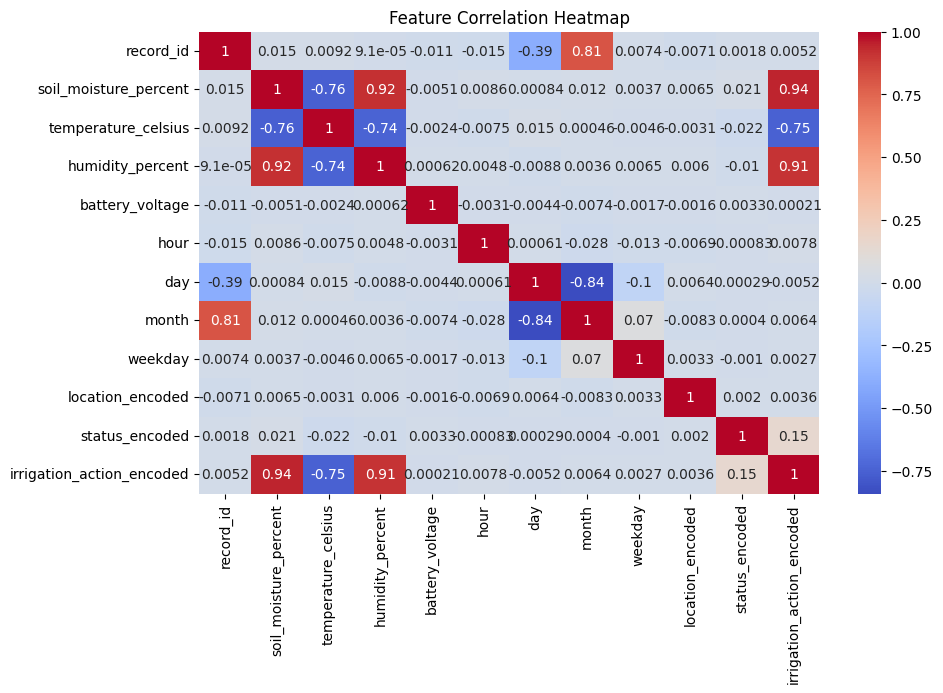

In [56]:
#reltionship between nummerical feautures
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [57]:
df.drop(['record_id', 'sensor_id', 'location', 'timestamp', 'status', 'irrigation_action','status_encoded'], axis=1, inplace=True)
df.to_csv('cleaned_soil_moisture_dataset.csv', index=False)

In [58]:
features = ['temperature_celsius', 'humidity_percent', 'battery_voltage', 'hour', 'day', 'month', 'weekday', 'location_encoded' ]

X = df[features]
y_moisture = df['soil_moisture_percent']  # Regression
y_action = df['irrigation_action_encoded']  # Classification


In [59]:
#data splitting
X_train, X_test, y_moisture_train, y_moisture_test, y_action_train, y_action_test = train_test_split(
    X, y_moisture, y_action, test_size=0.2, random_state=42,stratify=y_action
)

In [60]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert pandas Series to NumPy arrays and reshape
y_moisture_train = y_moisture_train.to_numpy().reshape(-1, 1)
y_moisture_test = y_moisture_test.to_numpy().reshape(-1, 1)

# Scale moisture target (regression output)
moisture_scaler = StandardScaler()
y_moisture_train_scaled = moisture_scaler.fit_transform(y_moisture_train)
y_moisture_test_scaled = moisture_scaler.transform(y_moisture_test)

with open('moisture_scaler.pkl', 'wb') as f:
    pickle.dump(moisture_scaler, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)



In [61]:
from tensorflow.keras.layers import Input, Dense # type: ignore
from tensorflow.keras.models import Model # type: ignore

# Input layer
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Shared layers
x = Dense(128, activation='relu')(input_layer)
x = Dense(256, activation='relu')(x)

# Moisture output (regression)
moisture_level = Dense(1, activation='sigmoid', name='moisture_level')(x)


# Irrigation action output (classification)
action_hidden = Dense(64, activation='relu')(x)
num_classes = len(np.unique(y_action_train))  # number of unique classes

# Irrigation action output (classification)
irrigation_action = Dense(num_classes, activation='softmax', name='irrigation_action')(action_hidden)


# Build the model
model = Model(inputs=input_layer, outputs={
    'moisture_level': moisture_level,
    'irrigation_action': irrigation_action
})


In [62]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer='adam',
    loss={
        'moisture_level': 'mae',  
        'irrigation_action': 'sparse_categorical_crossentropy'
    },
    metrics={
        'moisture_level': 'mae',
        'irrigation_action': 'accuracy'
    }
)



In [63]:
# Train the model
history = model.fit(
    X_train_scaled,
    {
        'moisture_level': y_moisture_train_scaled,
        'irrigation_action': y_action_train
    },
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

final_epoch = len(history.history['loss']) - 1

print("\nFinal Training Metrics:")
print(f"Loss: {history.history['loss'][final_epoch]:.4f}")
print(f"Moisture Loss: {history.history['moisture_level_loss'][final_epoch]:.4f}")
print(f"Moisture MAE: {history.history['moisture_level_mae'][final_epoch]:.4f}")
print(f"Irrigation Loss: {history.history['irrigation_action_loss'][final_epoch]:.4f}")
print(f"Irrigation Accuracy: {history.history['irrigation_action_accuracy'][final_epoch]:.4f}")

print("\nFinal Validation Metrics:")
print(f"Val Loss: {history.history['val_loss'][final_epoch]:.4f}")
print(f"Val Moisture Loss: {history.history['val_moisture_level_loss'][final_epoch]:.4f}")
print(f"Val Moisture MAE: {history.history['val_moisture_level_mae'][final_epoch]:.4f}")
print(f"Val Irrigation Loss: {history.history['val_irrigation_action_loss'][final_epoch]:.4f}")
print(f"Val Irrigation Accuracy: {history.history['val_irrigation_action_accuracy'][final_epoch]:.4f}")



Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - irrigation_action_accuracy: 0.8772 - irrigation_action_loss: 0.2983 - loss: 0.9464 - moisture_level_loss: 0.6481 - moisture_level_mae: 0.6481 - val_irrigation_action_accuracy: 0.9129 - val_irrigation_action_loss: 0.1923 - val_loss: 0.7908 - val_moisture_level_loss: 0.5985 - val_moisture_level_mae: 0.5985
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - irrigation_action_accuracy: 0.9157 - irrigation_action_loss: 0.1809 - loss: 0.7839 - moisture_level_loss: 0.6030 - moisture_level_mae: 0.6030 - val_irrigation_action_accuracy: 0.9149 - val_irrigation_action_loss: 0.1716 - val_loss: 0.7674 - val_moisture_level_loss: 0.5958 - val_moisture_level_mae: 0.5958
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - irrigation_action_accuracy: 0.9147 - irrigation_action_loss: 0.1678 - loss: 0.7713 - moisture_level_loss: 0.6036 - moisture_level_mae: 0.6036 - val_irrigation_action_accuracy: 0.9141 - val_irrigation_action_loss: 0.

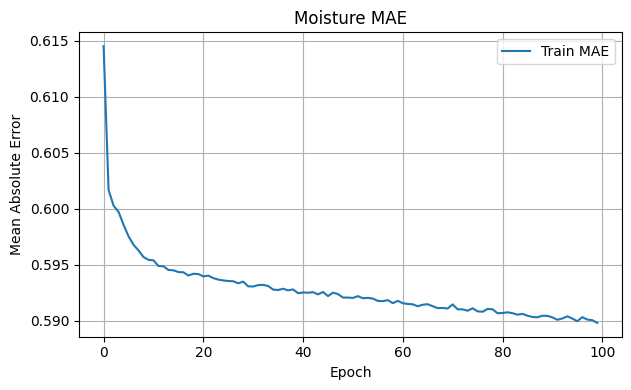

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['moisture_level_mae'], label='Train MAE')
plt.title('Moisture MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [65]:

model.save('soil_moisture_model.keras')

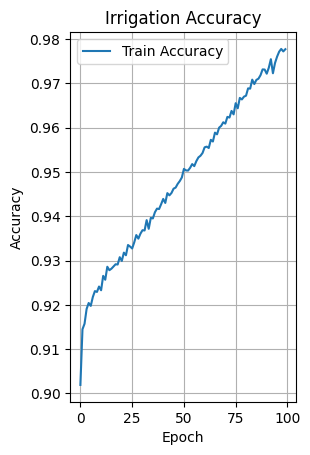

In [66]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(history.history['irrigation_action_accuracy'], label='Train Accuracy')
plt.title('Irrigation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()



In [152]:
import numpy as np
import pickle
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import load_model # type: ignore

# Load saved model and scalers
model = load_model('soil_moisture_model.keras', compile=False)

with open('feature_scaler.pkl', 'rb') as f:
    feature_scaler = pickle.load(f)

with open('moisture_scaler.pkl', 'rb') as f:
    moisture_scaler = pickle.load(f)

with open('action_encoder.pkl', 'rb') as f:
    irrigation_encoder = pickle.load(f)

features = ['temperature_celsius', 'humidity_percent', 'battery_voltage',
            'hour', 'day', 'month', 'weekday', 'location_encoded']

def predict_soil(sample_data: dict):
    # Prepare input array and scale features
    sample_input = np.array([[sample_data[feat] for feat in features]])
    sample_input_scaled = feature_scaler.transform(sample_input)
    
    # Predict
    output = model.predict(sample_input_scaled)
    pred_moisture = output['moisture_level']
    pred_irrigation = output['irrigation_action']
    
    # Convert moisture back from [0,1] to [0,100]
    moisture_value = moisture_scaler.inverse_transform(pred_moisture.reshape(1, -1))[0][0]
    
    # Decode irrigation action label
    irrigation_index = np.argmax(pred_irrigation[0])
    irrigation_action = irrigation_encoder.inverse_transform([irrigation_index])[0]
    
    return moisture_value, irrigation_action

# Example usage
sample_data = {
    'temperature_celsius': 17,
    'humidity_percent':65.0,
    'battery_voltage': 3.5,
    'hour': 5,
    'day': 6,
    'month': 10,
    'weekday': 3,
    'location_encoded': 2,
}

moisture_value, irrigation_action = predict_soil(sample_data)

print(f"Predicted Moisture Level: {moisture_value:.2f}%")
print(f"Predicted Irrigation Action: {irrigation_action}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Moisture Level: 79.75%
Predicted Irrigation Action: Reduce Irrigation
